# Signal and noise histograms per plan

In [1]:
%matplotlib inline

import numpy as np
import scipy
import math
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

from matplotlib.collections import LineCollection

import sys
sys.path.append("../")

import datapipe
from datapipe.io.images import image_generator
from datapipe.denoising.wavelets_mrtransform import wavelet_transform

In [2]:
from datapipe.denoising.inverse_transform_sampling import EmpiricalDistribution
import datapipe.denoising.cdf

## Common functions

In [3]:
IMG_SIZE = 7

def plot_hist(data_list,
              threshold_list,
              data_list2=None,
              data_list3=None,
              data_list4=None,
              suptitle=None,
              title_list=None,
              log=True,
              label_list=(None, )):
    
    num_imgs = len(data_list)
    
    fig, ax_list = plt.subplots(ncols=num_imgs, figsize=(num_imgs*IMG_SIZE, IMG_SIZE), squeeze=True)
    
    if title_list is None:
        title_list = [str(i) for i in range(len(data_list))]

    for data, threshold, title, ax in zip(data_list, threshold_list, title_list, ax_list):
        ax.set_title(title)
        
        data_min = min(data)
        data_max = max(data)
        bins = np.arange(math.floor(data_min), math.ceil(data_max) + 1)

        ax.hist(data, log=log, bins=bins, label=label_list[0])
        ax.axvline(threshold, color="r")
    
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        
    if data_list2 is not None:
        for data, ax in zip(data_list2, ax_list):
            data_min = min(data)
            data_max = max(data)
            bins = np.arange(math.floor(data_min), math.ceil(data_max) + 1)

            ax.hist(data, log=log, bins=bins, alpha=0.5, label=label_list[1])
            
    if data_list3 is not None:
        for data, ax in zip(data_list3, ax_list):
            data_min = min(data)
            data_max = max(data)
            bins = np.arange(math.floor(data_min), math.ceil(data_max) + 1)

            ax.hist(data, log=log, bins=bins, alpha=0.5, label=label_list[2],
                    histtype='step', fill=False, color='b', linestyle='dashed', lw=3)
            
    if data_list4 is not None:
        for data, ax in zip(data_list4, ax_list):
            data_min = min(data)
            data_max = max(data)
            bins = np.arange(math.floor(data_min), math.ceil(data_max) + 1)

            ax.hist(data, log=log, bins=bins, alpha=0.5, label=label_list[3],
                    histtype='step', fill=False, color='r', linestyle='dashed', lw=3)

    for ax in ax_list:
        ax.legend(prop={'size': 14}, loc='best', fancybox=True, framealpha=0.5)

    plt.suptitle(suptitle, fontsize=16)
    
    plt.show()

In [4]:
def get_samples(path_list,
                tel_filter_list=None,
                max_num_images=None,
                file=None,
                load=False):

    if load:
        in_sample_array = np.load(file + "_in.npy")
        ref_sample_array = np.load(file + "_ref.npy")
        noise_sample_array = np.load(file + "_noise.npy")
    else:
        in_sample_list = [[] for i in range(4)]
        ref_sample_list = [[] for i in range(4)]
        noise_sample_list = [[] for i in range(4)]

        noise_injection = True

        for images, metadata in image_generator(path_list,
                                                max_num_images=max_num_images,
                                                tel_filter_list=tel_filter_list):

            # Make ref, input and noise images #################

            in_img = images["input_image"]
            ref_img = images["reference_image"]

            noise_img = np.copy(in_img)
            noise_img[ref_img != 0.] = np.nan

            # Inject noise in NaN pixels #######################

            in_nan_mask = np.isnan(in_img)
            ref_nan_mask = np.isnan(ref_img)
            noise_nan_mask = np.isnan(noise_img)

            if noise_injection:
                if metadata['cam_id'] == 'ASTRI':
                    dist = EmpiricalDistribution(datapipe.denoising.cdf.ASTRI_CDF_FILE)

                elif metadata['cam_id'] in ('GATE', 'CHEC'):
                    dist = EmpiricalDistribution(datapipe.denoising.cdf.GCT_CDF_FILE)

                elif metadata['cam_id'] == 'DigiCam':
                    dist = EmpiricalDistribution(datapipe.denoising.cdf.DIGICAM_CDF_FILE)

                elif metadata['cam_id'] == 'FlashCam':
                    dist = EmpiricalDistribution(datapipe.denoising.cdf.FLASHCAM_CDF_FILE)

                elif metadata['cam_id'] == 'NectarCam':
                    dist = EmpiricalDistribution(datapipe.denoising.cdf.NECTARCAM_CDF_FILE)

                elif metadata['cam_id'] == 'LSTCam':
                    dist = EmpiricalDistribution(datapipe.denoising.cdf.LSTCAM_CDF_FILE)

                else:
                    raise ValueError("Wrong cam_id", metadata['cam_id'])

                in_img[in_nan_mask] = dist.rvs(size=np.count_nonzero(in_nan_mask))

                ref_img[ref_nan_mask] = 0.

                noise_img[noise_nan_mask] = dist.rvs(size=np.count_nonzero(noise_nan_mask))

            # Apply Wavelet transform ##########################

            in_plan_imgs = wavelet_transform(in_img)
            ref_plan_imgs = wavelet_transform(ref_img)
            noise_plan_imgs = wavelet_transform(noise_img)

            # "Normalize plans" ################################

            #for plan in in_plan_imgs:
            #    std = plan.std()
            #    plan /= std

            #for plan in ref_plan_imgs:
            #    std = plan.std()
            #    plan /= std

            #for plan in noise_plan_imgs:
            #    std = plan.std()
            #    plan /= std

            # Filter NaN pixels ################################

            for plan in in_plan_imgs:
                plan[in_nan_mask] = np.nan

            for plan in ref_plan_imgs:
                plan[ref_nan_mask] = np.nan

            for plan in noise_plan_imgs:
                plan[noise_nan_mask] = np.nan

            # Add samples ######################################

            for plan_index in range(4):
                in_sample_list[plan_index].extend(in_plan_imgs[plan_index][np.logical_not(in_nan_mask)].tolist())

            for plan_index in range(4):
                ref_sample_list[plan_index].extend(ref_plan_imgs[plan_index][np.logical_not(ref_nan_mask)].tolist())

            for plan_index in range(4):
                noise_sample_list[plan_index].extend(noise_plan_imgs[plan_index][np.logical_not(noise_nan_mask)].tolist())

        in_sample_array = np.array(in_sample_list)
        del in_sample_list
        ref_sample_array = np.array(ref_sample_list)
        del ref_sample_list
        noise_sample_array = np.array(noise_sample_list)
        del noise_sample_list

        if file is not None:
            np.save(file + "_in.npy", in_sample_array)
            np.save(file + "_ref.npy", ref_sample_array)
            np.save(file + "_noise.npy", noise_sample_array)
    
    return in_sample_array, ref_sample_array, noise_sample_array

In [5]:
NUM_IMAGES = 2000
LOAD = False         # Set True to load previously saved data

## SST-1M

In [6]:
%%time

path_list = ['/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/']

gamma_samples = get_samples(path_list,
                            tel_filter_list=None,
                            max_num_images=NUM_IMAGES,
                            file="hist_plans_gamma_digicam_samples",
                            load=LOAD)

path_list = ['/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/proton/']

proton_samples = get_samples(path_list,
                             tel_filter_list=None,
                             max_num_images=NUM_IMAGES,
                             file="hist_plans_proton_digicam_samples_nonorm",
                             load=LOAD)

CPU times: user 2min 35s, sys: 1min 43s, total: 4min 18s
Wall time: 1h 17min 6s


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


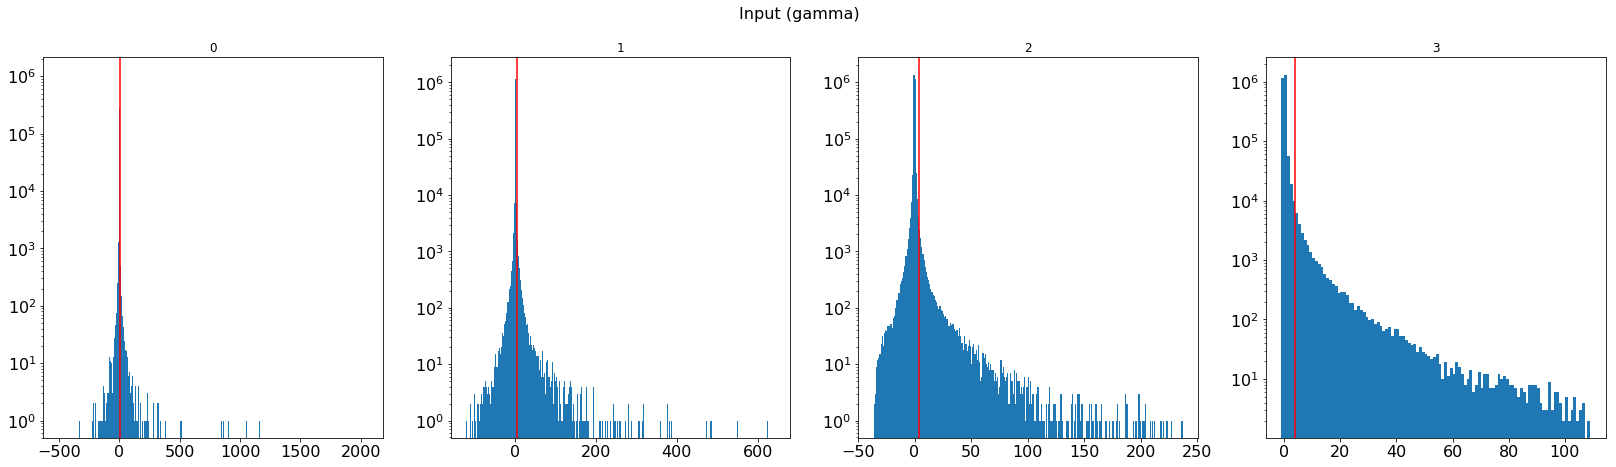

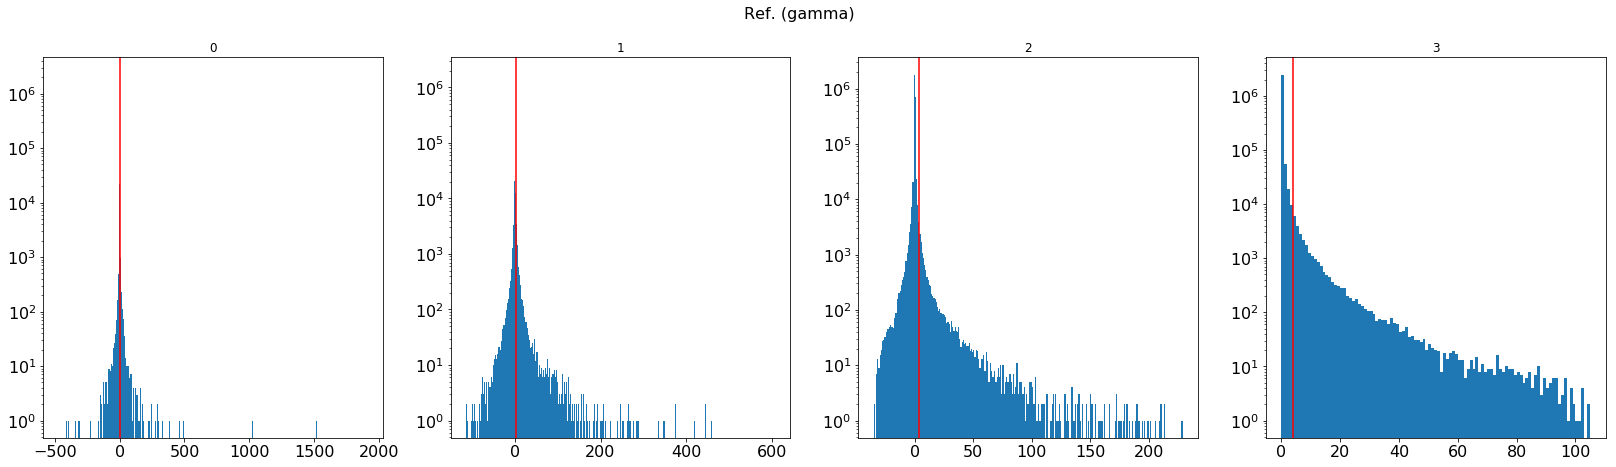

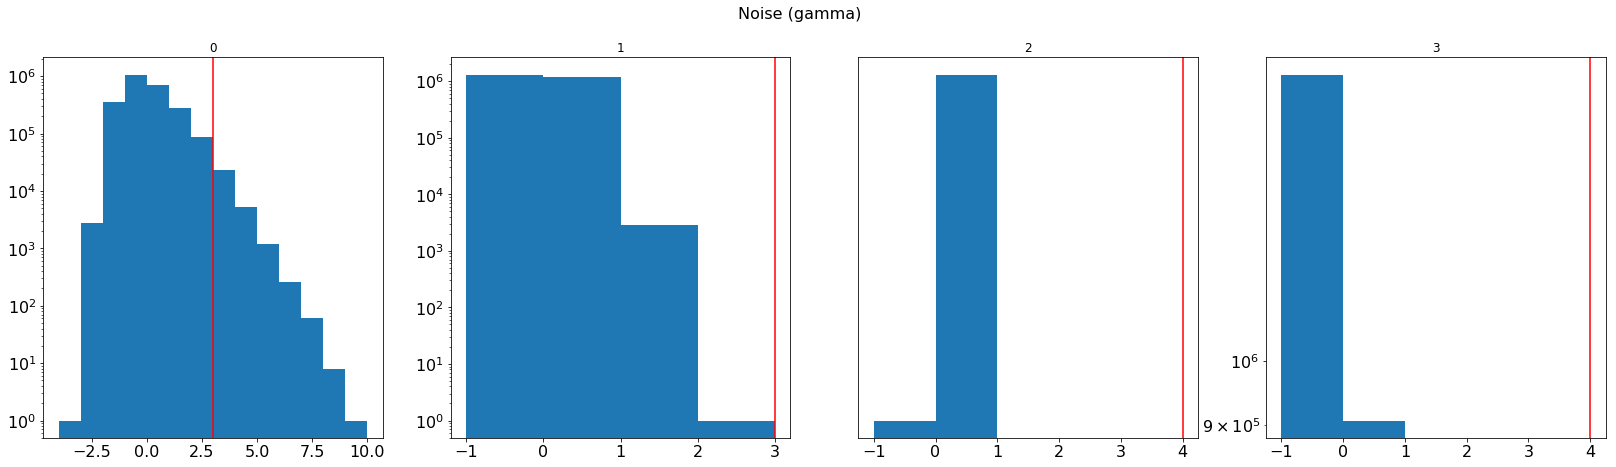

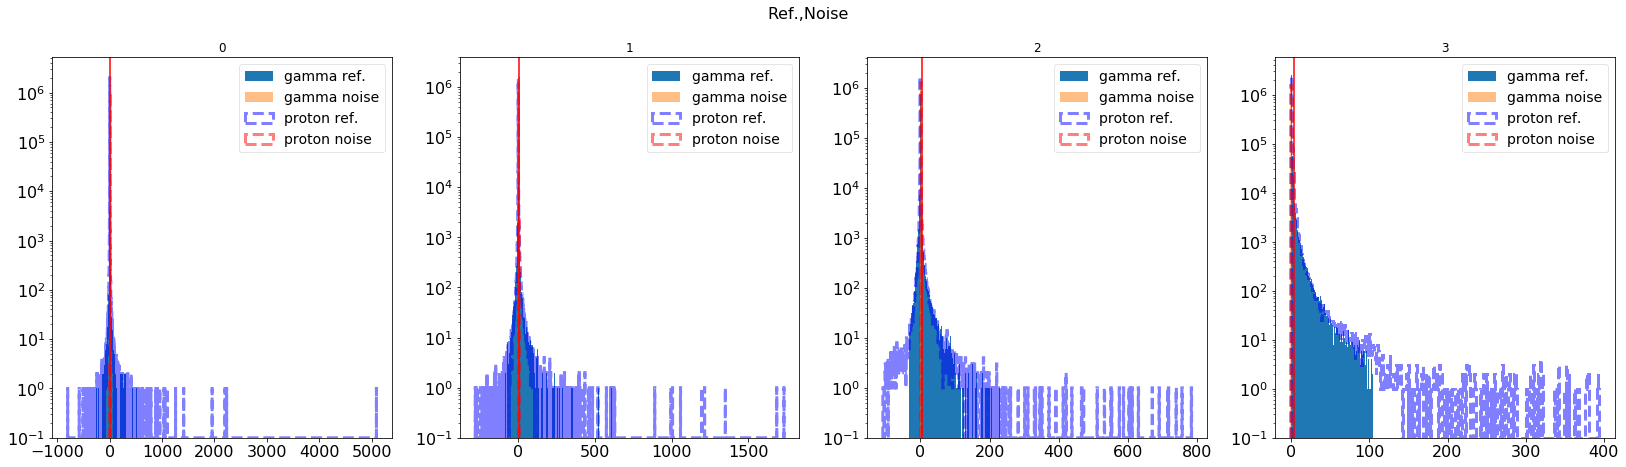

In [7]:
digicam_thresholds = [3, 3, 4, 4]
#digicam_thresholds = [2.5, 2.5, 4.5, 1.]

plot_hist(gamma_samples[0], threshold_list=digicam_thresholds, suptitle="Input (gamma)")
plot_hist(gamma_samples[1], threshold_list=digicam_thresholds, suptitle="Ref. (gamma)")
plot_hist(gamma_samples[2], threshold_list=digicam_thresholds, suptitle="Noise (gamma)")

plot_hist(gamma_samples[1],
          threshold_list=digicam_thresholds,
          data_list2=gamma_samples[2],
          data_list3=proton_samples[1],
          data_list4=proton_samples[2],
          suptitle="Ref.,Noise",
          label_list=["gamma ref.", "gamma noise", "proton ref.", "proton noise"])

In [ ]:
del gamma_samples
del proton_samples

## NectarCam

In [11]:
%%time

path_list = ['/Users/jdecock/data/grid_prod3b_north/fits/nectarcam/gamma/']

gamma_samples = get_samples(path_list,
                            tel_filter_list=None,
                            max_num_images=NUM_IMAGES,
                            file="hist_plans_gamma_nectarcam_samples",
                            load=LOAD)

path_list = ['/Users/jdecock/data/grid_prod3b_north/fits/nectarcam/proton/']

proton_samples = get_samples(path_list,
                             tel_filter_list=None,
                             max_num_images=NUM_IMAGES,
                             file="hist_plans_proton_nectarcam_samples_nonorm",
                             load=LOAD)

CPU times: user 2min 36s, sys: 3min 39s, total: 6min 16s
Wall time: 51min 51s


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


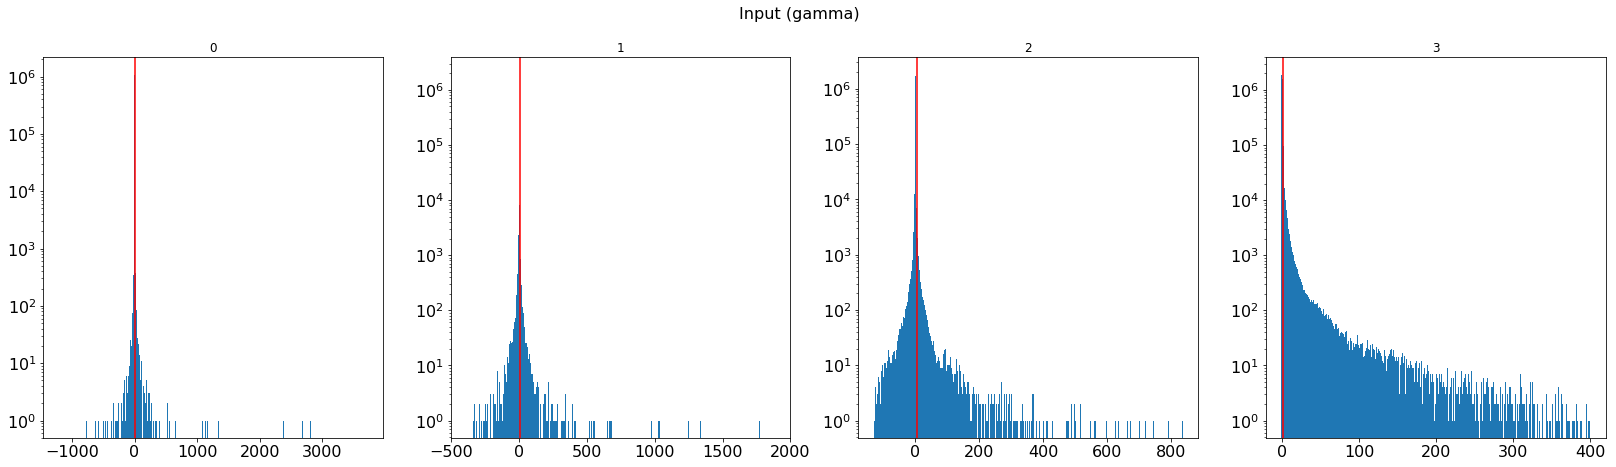

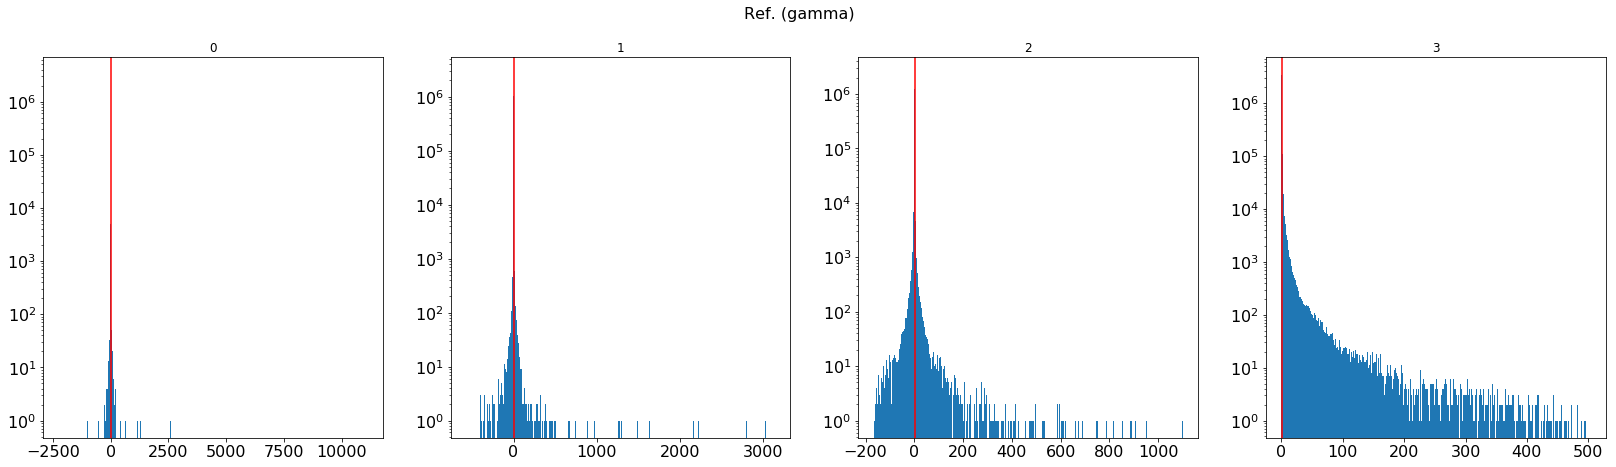

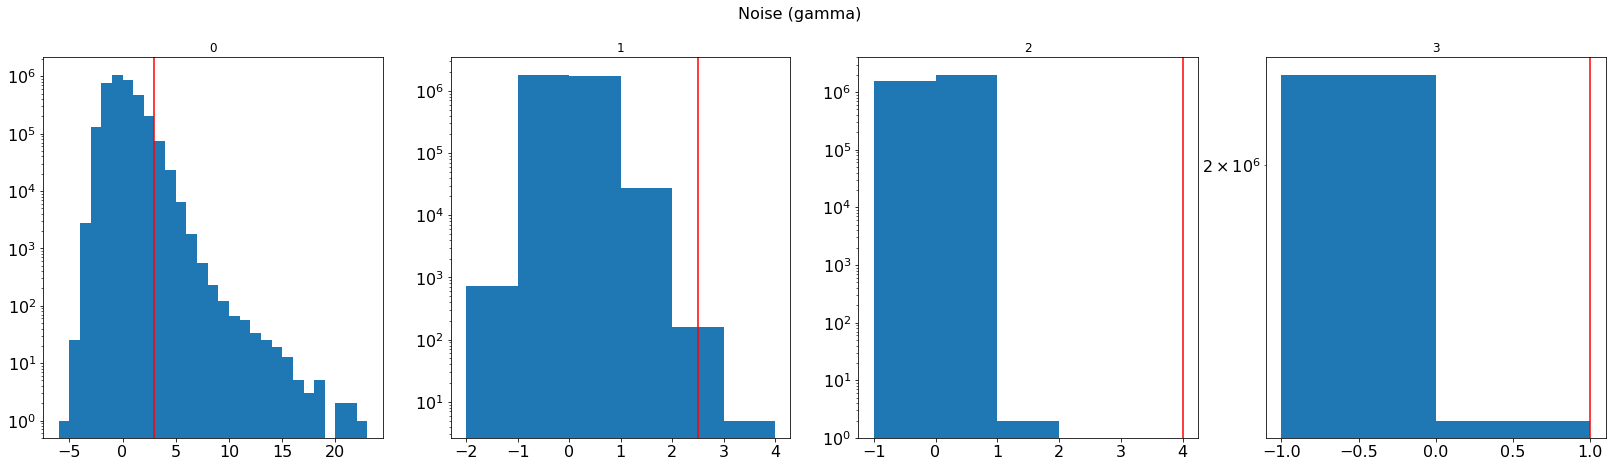

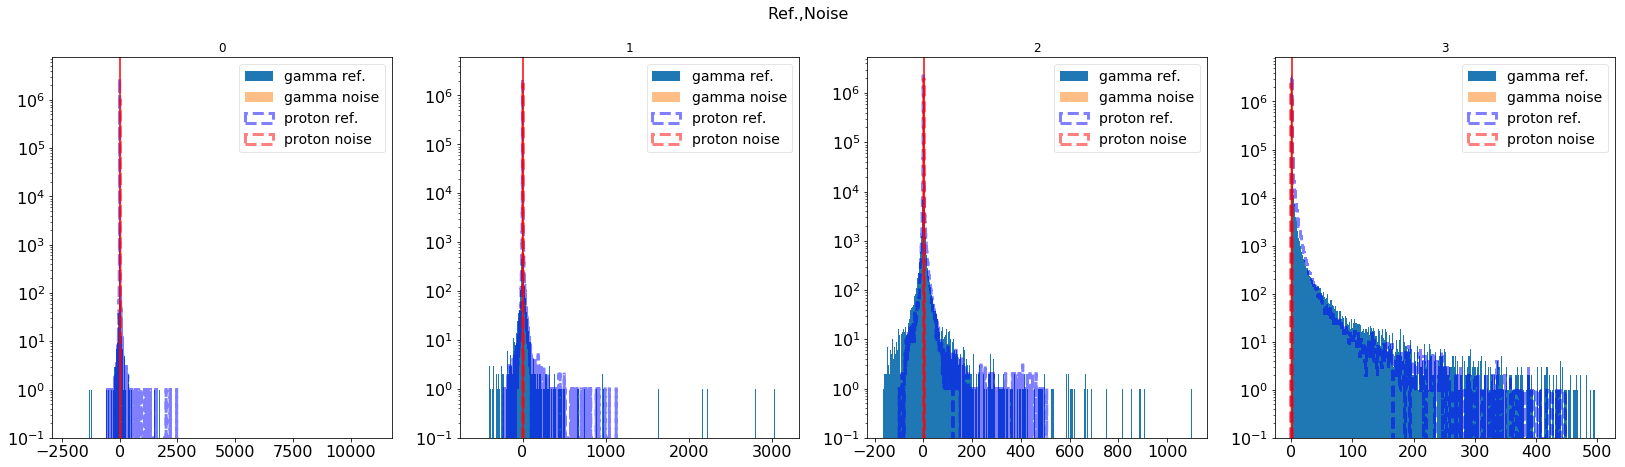

In [12]:
nectarcam_thresholds = [3, 2.5, 4, 1]

plot_hist(gamma_samples[0], threshold_list=nectarcam_thresholds, suptitle="Input (gamma)")
plot_hist(gamma_samples[1], threshold_list=nectarcam_thresholds, suptitle="Ref. (gamma)")
plot_hist(gamma_samples[2], threshold_list=nectarcam_thresholds, suptitle="Noise (gamma)")

plot_hist(gamma_samples[1],
          threshold_list=nectarcam_thresholds,
          data_list2=gamma_samples[2],
          data_list3=proton_samples[1],
          data_list4=proton_samples[2],
          suptitle="Ref.,Noise",
          label_list=["gamma ref.", "gamma noise", "proton ref.", "proton noise"])

In [13]:
del gamma_samples
del proton_samples

## LSTCam

In [14]:
%%time

path_list = ['/Users/jdecock/data/grid_prod3b_north/fits/lst/gamma/']

gamma_samples = get_samples(path_list,
                            tel_filter_list=None,
                            max_num_images=NUM_IMAGES,
                            file="hist_plans_gamma_lstcam_samples",
                            load=LOAD)

path_list = ['/Users/jdecock/data/grid_prod3b_north/fits/lst/proton/']

proton_samples = get_samples(path_list,
                             tel_filter_list=None,
                             max_num_images=NUM_IMAGES,
                             file="hist_plans_proton_lstcam_samples_nonorm",
                             load=LOAD)

CPU times: user 2min 35s, sys: 8min 54s, total: 11min 29s
Wall time: 56min 11s


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


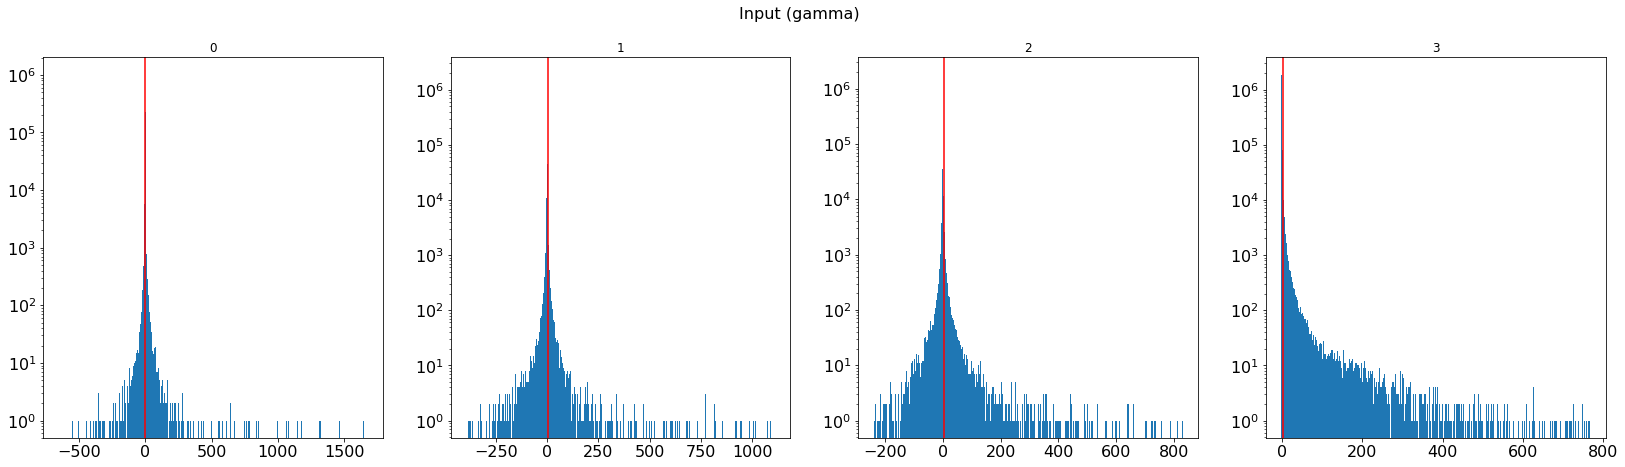

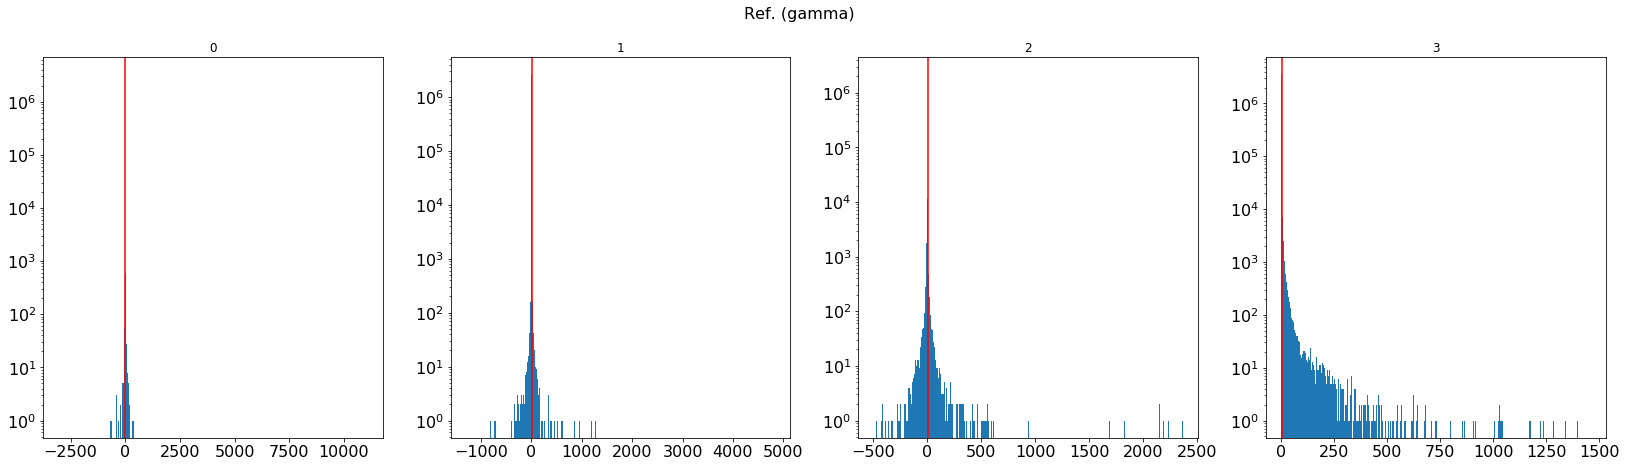

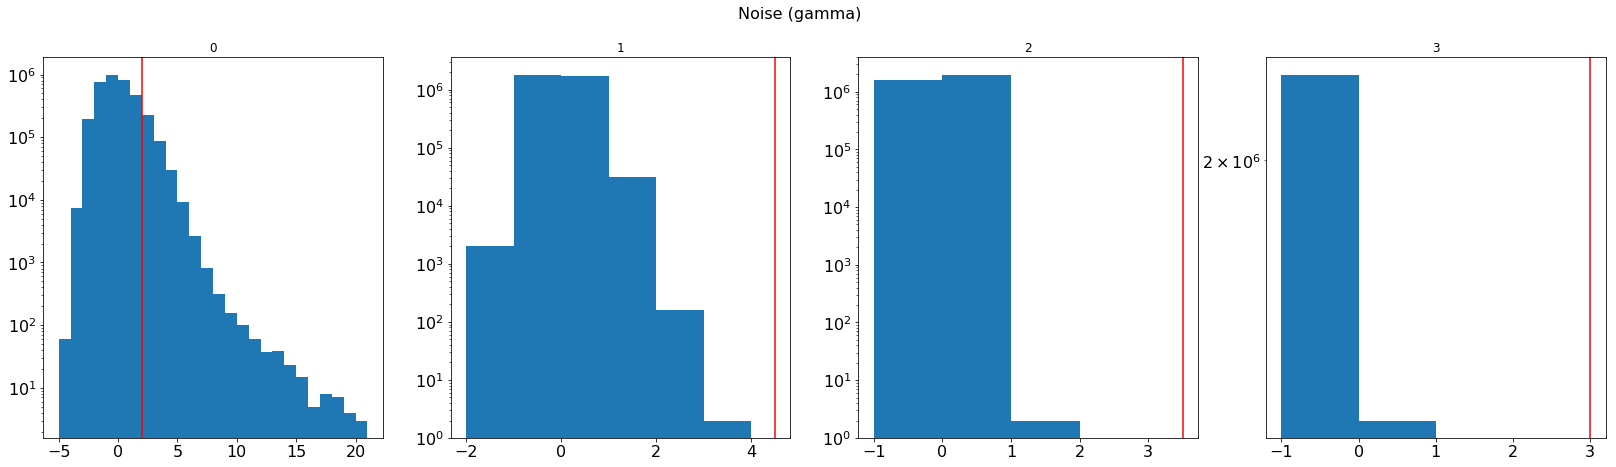

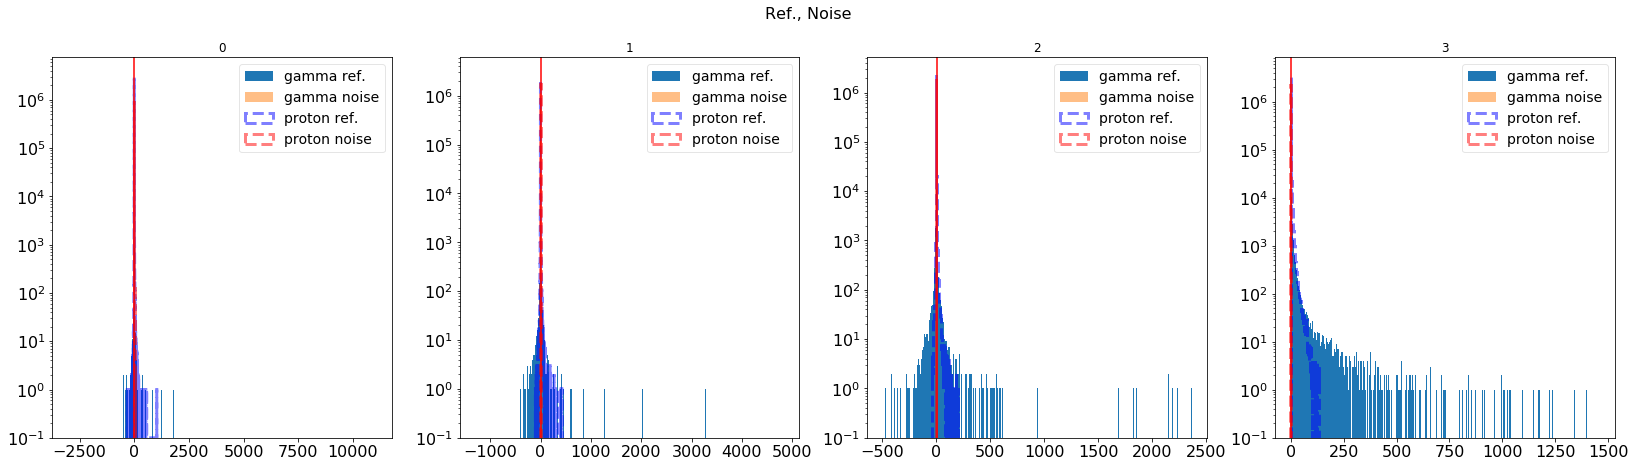

In [15]:
lstcam_thresholds = [2, 4.5, 3.5, 3]

plot_hist(gamma_samples[0], threshold_list=lstcam_thresholds, suptitle="Input (gamma)")
plot_hist(gamma_samples[1], threshold_list=lstcam_thresholds, suptitle="Ref. (gamma)")
plot_hist(gamma_samples[2], threshold_list=lstcam_thresholds, suptitle="Noise (gamma)")

plot_hist(gamma_samples[1],
          threshold_list=lstcam_thresholds,
          data_list2=gamma_samples[2],
          data_list3=proton_samples[1],
          data_list4=proton_samples[2],
          suptitle="Ref., Noise",
          label_list=["gamma ref.", "gamma noise", "proton ref.", "proton noise"])

In [16]:
del gamma_samples
del proton_samples

Wavelet thresholds should not be outside the Noise histogram range.